In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import entropy
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Load all the spike and value data

In [2]:
def load_nef_values(load=True):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        values['dvs'] = np.abs(values['va'] - values['vb'])
        values['dva'] = np.abs(values['vl'] - values['vr'])
        # values.rename(columns={'wab': 'w'}, inplace=True)
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [18]:
def load_rl_values(load=True):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            pass
        values = pd.concat(dfs, ignore_index=True)
        values = values.drop(columns='omega')
        values = values.dropna()
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [4]:
def load_nef_spikes(load=True, save_combined=True):
    if load:
        with open('data/nef_spikes_condensed.pkl', 'rb') as file:
            nef_spikes = pickle.load(file)
    else:
        nef_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            nef_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                nef_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    nef_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        v = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['v'].sum(axis=0)  # sum over time
                        w = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['w'].sum(axis=0)  # sum over time
                        a = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['a'].sum(axis=0)  # sum over time
                        # vwa = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa'].sum(axis=0)  # sum over time
                        # evc = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['evc'].sum(axis=0)  # sum over time
                        # ewt = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['ewt'].sum(axis=0)  # sum over time
                        if save_combined:
                            combined = np.concatenate([v,w,a], axis=0)
                            # combined = np.concatenate([v,w,a,vwa,evc,ewt], axis=0)
                            nef_spikes[monkey][session][block][trial] = combined
                        else:
                            nef_spikes[monkey][session][block][trial] = {}
                            nef_spikes[monkey][session][block][trial]['v'] = v
                            nef_spikes[monkey][session][block][trial]['w'] = w
                            nef_spikes[monkey][session][block][trial]['a'] = a
                            # nef_spikes[monkey][session][block][trial]['vwa'] = vwa
                            # nef_spikes[monkey][session][block][trial]['evc'] = evc
                            # nef_spikes[monkey][session][block][trial]['ewt'] = ewt
        filename = "nef_spikes_condensed" if save_combined else "nef_spikes_bypop"
        with open(f'data/{filename}.pkl', 'wb') as f:
            pickle.dump(nef_spikes, f)
    return nef_spikes

In [5]:
def load_monkey_spikes(load=True):
    if load:
        with open('data/monkey_spikes_condensed.pkl', 'rb') as file:
            emp_spikes = pickle.load(file)
    else:
        emp_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            emp_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                emp_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    emp_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        try:
                            emp_spikes[monkey][session][block][trial] = np.load(
                                f"data/emp_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['spikes']
                        except:
                            pass
        with open('data/monkey_spikes_condensed.pkl', 'wb') as f:
            pickle.dump(emp_spikes, f)
    return emp_spikes

In [28]:
nef_values = load_nef_values(load=True)
rl_values = load_rl_values(load=False)

In [11]:
nef_spikes = load_nef_spikes(load=True)
monkey_spikes = load_monkey_spikes(load=True)

# Use linear regression to predict values using spikes

In [15]:
def clean_paired_array_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must be of equal length.")
    
    # Step 1: Remove pairs where list1 has NaNs
    filtered_pairs = [(a1, a2) for a1, a2 in zip(list1, list2) if not np.isnan(a1).any()]
    
    if not filtered_pairs:
        return [], []

    # Step 2: Find the most common shape in list1 after filtering NaNs
    shapes = [a1.shape for a1, _ in filtered_pairs]
    most_common_shape = Counter(shapes).most_common(1)[0][0]

    # Step 3: Keep only pairs where a1 has the most common shape
    cleaned_list1 = [a1 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]
    cleaned_list2 = [a2 for a1, a2 in filtered_pairs if a1.shape == most_common_shape]

    return np.array(cleaned_list1), np.array(cleaned_list2)

In [26]:
def regress_spikes_values(spikes, values, value_type):
    dfs_error = []
    dfs_trial = []
    if value_type=='rl':
        variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'dw', 'dvc', 'dvs', 'dva']
    elif value_type=='nef':
        variables = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr', 'al', 'ar', 'evc', 'ewt']
    columns_error = ['monkey', 'session', 'variable', 'error']
    columns_trial = ['monkey', 'session', 'block', 'trial', 'var', 'true_value', 'pred_value', 'abs_perc_err']
    regression_dict = {}
    for monkey in ['V', 'W']:
        regression_dict[monkey] = {}
        for session in [0,1,2,3]:
            regression_dict[monkey][session] = {}
            for variable in variables:
                print(monkey, session, variable)
                X = []
                Y = []
                for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        try:
                            x = spikes[monkey][session][block][trial]
                            y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()
                            X.append(x)
                            Y.append(y)
                        except:
                            pass
                X, Y = clean_paired_array_lists(X, Y)
                pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
                pipeline.fit(X, Y)
                regression_dict[monkey][session][variable] = pipeline
                scoring = make_scorer(mean_squared_error, greater_is_better=False)
                cv_scores = cross_val_score(pipeline, X, Y, cv=10, scoring=scoring)
                mse = np.mean(-cv_scores)
                dfs_error.append(pd.DataFrame([[monkey, session, variable, mse]], columns=columns_error))
                # for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                #     for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                #         x = spikes[monkey][session][block][trial].reshape(-1,1).T
                #         y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()[0]
                for i in range(len(X)):
                    x, y = X[i], Y[i][0]
                    y_pred = regression_dict[monkey][session][variable].predict(x.reshape(-1,1).T)[0]
                    e = np.abs(y-y_pred)/y if y!=0 else None
                    dfs_trial.append(pd.DataFrame([[monkey, session, block, trial, variable, y, y_pred, e]], columns=columns_trial))
    data_error = pd.concat(dfs_error, ignore_index=True)
    data_trial = pd.concat(dfs_trial, ignore_index=True)
    data_error.to_pickle("data/data_error.pkl")
    data_trial.to_pickle("data/data_trial.pkl")
    return data_error, data_trial

# NEF

In [43]:
nef_error, nef_trial = regress_spikes_values(nef_spikes, nef_values, 'nef')

V 0 va
V 0 vb
V 0 vl
V 0 vr
V 0 wab
V 0 wlr
V 0 al
V 0 ar
V 0 dvs
V 0 dva
V 1 va
V 1 vb
V 1 vl
V 1 vr
V 1 wab
V 1 wlr
V 1 al
V 1 ar
V 1 dvs
V 1 dva
V 2 va
V 2 vb
V 2 vl
V 2 vr
V 2 wab
V 2 wlr
V 2 al
V 2 ar
V 2 dvs
V 2 dva
V 3 va
V 3 vb
V 3 vl
V 3 vr
V 3 wab
V 3 wlr
V 3 al
V 3 ar
V 3 dvs
V 3 dva
W 0 va
W 0 vb
W 0 vl
W 0 vr
W 0 wab
W 0 wlr
W 0 al
W 0 ar
W 0 dvs
W 0 dva
W 1 va
W 1 vb
W 1 vl
W 1 vr
W 1 wab
W 1 wlr
W 1 al
W 1 ar
W 1 dvs
W 1 dva
W 2 va
W 2 vb
W 2 vl
W 2 vr
W 2 wab
W 2 wlr
W 2 al
W 2 ar
W 2 dvs
W 2 dva
W 3 va
W 3 vb
W 3 vl
W 3 vr
W 3 wab
W 3 wlr
W 3 al
W 3 ar
W 3 dvs
W 3 dva


In [228]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=False, sharey=False)
# sns.kdeplot(nef_trial, x='true_value', hue='var', ax=axes, palette=palette)
# axes.set(title="RL Distribution", xlabel='Ground Truth Values')
# plt.tight_layout()

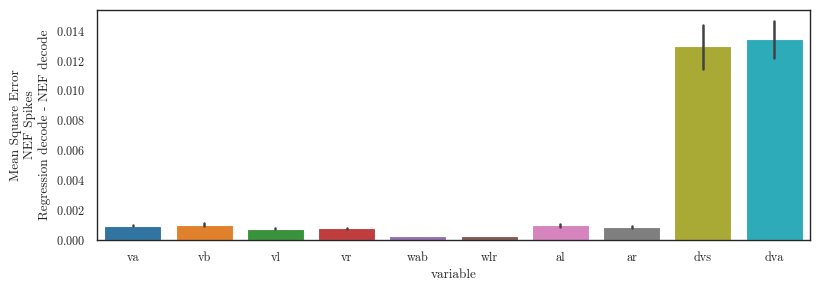

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(nef_error, x='variable', y='error', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="Cross Validation Error\nNEF Spikes\nRegression decode - NEF decode")
fig.savefig("plots/nef_spikes_nef_values_error.jpg", dpi=600)

In [229]:
# nef_wab = nef_trial.query("var=='wab'")['true_value'].to_numpy()
# nef_wlr = nef_trial.query("var=='wlr'")['true_value'].to_numpy()
# nef_dvs = np.abs(nef_trial.query("var=='va'")['true_value'].to_numpy() - nef_trial.query("var=='vb'")['true_value'].to_numpy())
# nef_dva = np.abs(nef_trial.query("var=='vl'")['true_value'].to_numpy() - nef_trial.query("var=='vr'")['true_value'].to_numpy())
# nef_p_stim = nef_dvs / (nef_dvs + nef_dva)
# nef_p_act = nef_dva / (nef_dvs + nef_dva)

# w_bins = np.linspace(0, 1, 20)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=True, sharey=True)
# sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes, color=palette[0], label='deltaQ-stim')
# sns.regplot(x=1-nef_wlr, y=nef_p_act, x_bins=w_bins, ax=axes, color=palette[1], label='deltaQ-act')
# axes.legend()
# axes.set(ylabel="DeltaQ-i / deltaQ-total", xlim=(0.2, 0.8), ylim=(0, 1), title="NEF spikes, Regression decode", xlabel='Omega')
# plt.tight_layout()

# RL

In [29]:
monkey_error, monkey_trial = regress_spikes_values(monkey_spikes, rl_values, 'rl')

V 0 va
V 0 vb
V 0 vl
V 0 vr
V 0 w
V 0 al
V 0 ar
V 0 dw
V 0 dvc
V 0 dvs
V 0 dva
V 1 va
V 1 vb
V 1 vl
V 1 vr
V 1 w
V 1 al
V 1 ar
V 1 dw
V 1 dvc
V 1 dvs
V 1 dva
V 2 va
V 2 vb
V 2 vl
V 2 vr
V 2 w
V 2 al
V 2 ar
V 2 dw
V 2 dvc
V 2 dvs
V 2 dva
V 3 va
V 3 vb
V 3 vl
V 3 vr
V 3 w
V 3 al
V 3 ar
V 3 dw
V 3 dvc
V 3 dvs
V 3 dva
W 0 va
W 0 vb
W 0 vl
W 0 vr
W 0 w
W 0 al
W 0 ar
W 0 dw
W 0 dvc
W 0 dvs
W 0 dva
W 1 va
W 1 vb
W 1 vl
W 1 vr
W 1 w
W 1 al
W 1 ar
W 1 dw
W 1 dvc
W 1 dvs
W 1 dva
W 2 va
W 2 vb
W 2 vl
W 2 vr
W 2 w
W 2 al
W 2 ar
W 2 dw
W 2 dvc
W 2 dvs
W 2 dva
W 3 va
W 3 vb
W 3 vl
W 3 vr
W 3 w
W 3 al
W 3 ar
W 3 dw
W 3 dvc
W 3 dvs
W 3 dva


/tmp/ipykernel_300693/3822365750.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_trial = pd.concat(dfs_trial, ignore_index=True)


In [231]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=False, sharey=False)
# sns.kdeplot(monkey_trial, x='true_value', hue='var', ax=axes, palette=palette)
# axes.set(title="RL Distribution", xlabel='Ground Truth Values')
# plt.tight_layout()

In [232]:
# rl_w = monkey_trial.query("var=='w'")['true_value'].to_numpy()
# rl_dvs = np.abs(monkey_trial.query("var=='va'")['true_value'].to_numpy() - monkey_trial.query("var=='vb'")['true_value'].to_numpy())
# rl_dva = np.abs(monkey_trial.query("var=='vl'")['true_value'].to_numpy() - monkey_trial.query("var=='vr'")['true_value'].to_numpy())
# rl_p_stim = rl_dvs / (rl_dvs + rl_dva)
# rl_p_act = rl_dva / (rl_dvs + rl_dva)

# w_bins = np.linspace(0, 1, 20)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=True, sharey=True)
# sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes, color=palette[0], label='deltaQ-stim')
# sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes, color=palette[1], label='deltaQ-act')
# axes.legend()
# axes.set(ylabel="DeltaQ-i / deltaQ-total", xlim=(0.2, 0.8), ylim=(0, 1), title="RL values only", xlabel='Omega')
# plt.tight_layout()

# Monkey

/tmp/ipykernel_300693/2426119727.py:2: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(monkey_error, x='variable', y='error', hue='variable', ax=axes, palette=palette)


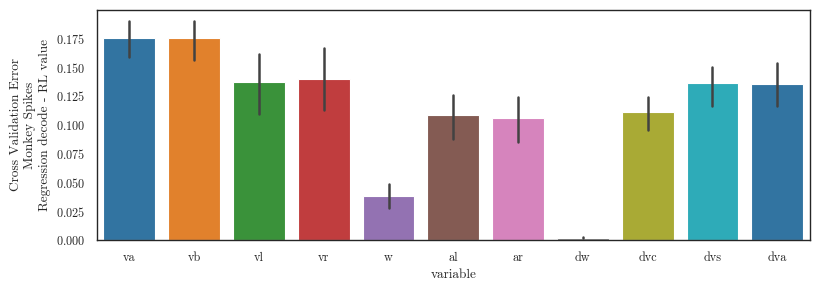

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(monkey_error, x='variable', y='error', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel="Cross Validation Error\nMonkey Spikes\nRegression decode - RL value")
fig.savefig("plots/monkey_spikes_rl_values_error.jpg", dpi=600)

In [234]:
# monkey_w = monkey_trial.query("var=='w'")['pred_value'].to_numpy()
# monkey_dvs = np.abs(monkey_trial.query("var=='va'")['pred_value'].to_numpy() - monkey_trial.query("var=='vb'")['pred_value'].to_numpy())
# monkey_dva = np.abs(monkey_trial.query("var=='vl'")['pred_value'].to_numpy() - monkey_trial.query("var=='vr'")['pred_value'].to_numpy())
# monkey_p_stim = monkey_dvs / (monkey_dvs + monkey_dva)
# monkey_p_act = monkey_dva / (monkey_dvs + monkey_dva)

# w_bins = np.linspace(0, 1, 20)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=True, sharey=True)
# sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes, color=palette[0], label='deltaQ-stim')
# sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes, color=palette[1], label='deltaQ-act')
# axes.legend()
# axes.set(ylabel="DeltaQ-i / deltaQ-total", xlim=(0.2, 0.8), ylim=(0, 1), title="Monkey spikes, regression decode", xlabel='Omega')
# plt.tight_layout()

# 3 omega plots together

In [235]:
# w_bins = np.linspace(0, 1, 20)
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,3), sharex=True, sharey=True)
# sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], label='deltaQ-stim')
# sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[0], color=palette[1], label='deltaQ-act')
# sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes[1], color=palette[0], label='deltaQ-stim')
# sns.regplot(x=1-nef_wlr, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], label='deltaQ-act')
# sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[2], color=palette[0], label='deltaQ-stim')
# sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[2], color=palette[1], label='deltaQ-act')
# axes[0].legend()
# axes[0].set(ylabel="DeltaQ-i / deltaQ-total", xlim=(0.2, 0.8), ylim=(0, 1), xlabel='Omega', title='RL')
# axes[1].set(title='NEF')
# axes[2].set(title='Monkey')
# plt.tight_layout()

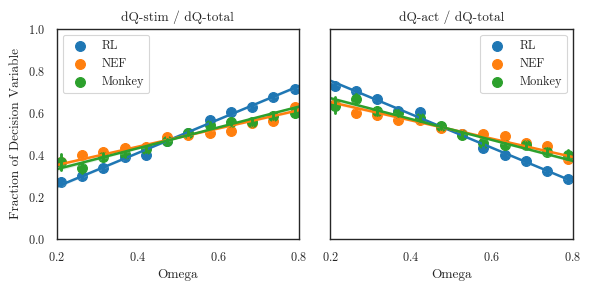

In [65]:
w_bins = np.linspace(0, 1, 20)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True)
sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes[0], color=palette[0], label='RL')
sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes[0], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes[0], color=palette[2], label='Monkey')
sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes[1], color=palette[0], label='RL')
sns.regplot(x=1-nef_wlr, y=nef_p_act, x_bins=w_bins, ax=axes[1], color=palette[1], label='NEF')
sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes[1], color=palette[2], label='Monkey')
axes[0].legend()
axes[1].legend()
axes[0].set(ylabel='Fraction of Decision Variable', title="dQ-stim / dQ-total", xlim=(0.2, 0.8), ylim=(0, 1), xlabel='Omega')
axes[1].set(title="dQ-act / dQ-total", xlabel='Omega')
plt.tight_layout()
fig.savefig("plots/fraction_DV_vs_omega.jpg", dpi=600)

In [236]:
# w_bins = np.linspace(0, 1, 20)
# line_kws = {'linestyle': '--'}
# scatter_kws = {'marker': 's'}
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3), sharex=True, sharey=True)
# sns.regplot(x=rl_w, y=rl_p_stim, x_bins=w_bins, ax=axes, color=palette[0], label='RL (Stim)')
# sns.regplot(x=nef_wab, y=nef_p_stim, x_bins=w_bins, ax=axes, color=palette[1], label='NEF (Stim)')
# sns.regplot(x=monkey_w, y=monkey_p_stim, x_bins=w_bins, ax=axes, color=palette[2], label='Monkey (Stim)')
# sns.regplot(x=rl_w, y=rl_p_act, x_bins=w_bins, ax=axes, color=palette[0], label='RL (Act)', line_kws=line_kws, scatter_kws=scatter_kws)
# sns.regplot(x=1-nef_wlr, y=nef_p_act, x_bins=w_bins, ax=axes, color=palette[1], label='NEF (Act)', line_kws=line_kws, scatter_kws=scatter_kws)
# sns.regplot(x=monkey_w, y=monkey_p_act, x_bins=w_bins, ax=axes, color=palette[2], label='Monkey (Act)', line_kws=line_kws, scatter_kws=scatter_kws)
# axes.legend()
# axes.set(ylabel='Fraction of Decision Variable', title="dQ-i / dQ-total", xlim=(0.2, 0.8), ylim=(0, 1), xlabel='Omega')
# plt.tight_layout()

# Neuron selectivity

In [33]:
def spike_entropy(spikes, values, spike_type, value_type, epsilon=1e-10, normalization='neuron'):
    dfs = []
    if value_type=='rl':
        variables = ['va', 'vb', 'vl', 'vr', 'w', 'al', 'ar', 'dvc', 'dvs', 'dva']  #  
    elif value_type=='nef':
        variables = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr', 'al', 'ar']  #  'evc', 'ewt'
    columns = ['monkey', 'session', 'neuron', 'population', 'variable', 'weight', 'norm_weight', 'entropy']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            X = []
            Y = []
            for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                    try:
                        X.append(spikes[monkey][session][block][trial])
                        y = []
                        for variable in variables:
                                yi = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()[0]
                                y.append(yi)
                        Y.append(y)
                    except:
                        pass
            X, Y = clean_paired_array_lists(X, Y)
            n_neurons = X.shape[1]
            pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
            pipeline.fit(X, Y)
            ridge = pipeline.named_steps['ridge']  # Extract weights (neurons × variables)
            sqr_weights = np.square(ridge.coef_.T)  # N × k (neurons × value variables)
            if normalization=='global':
                norm_weights = sqr_weights / (np.sum(sqr_weights) + epsilon) # Compute normalized squared weights
            elif normalization=='neuron':
                norm_weights = sqr_weights / (sqr_weights.sum(axis=1, keepdims=True) + epsilon) # Compute normalized squared weights
            entropies = entropy(norm_weights.T + epsilon)  # Entropy per neuron; shape: (neurons,)
            for v, variable in enumerate(variables):
                # print(v, variable)
                df = pd.DataFrame(columns=columns)
                df['monkey'] = [monkey for _ in range(n_neurons)]
                df['session'] = [session for _ in range(n_neurons)]
                df['neuron'] = [n for n in range(n_neurons)]
                if spike_type=='nef':
                    pops = []
                    for pop in ['v', 'w', 'a']:
                        pops.extend([pop for _ in range(int(n_neurons/3))])
                    df['population'] = pops
                else:
                    df['population'] = ['all' for n in range(n_neurons)]
                df['variable'] = [variable for _ in range(n_neurons)]
                df['entropy'] = entropies
                df['weight'] = sqr_weights[:,v]
                df['norm_weight'] = norm_weights[:,v]
                dfs.append(df)
    neuron_weights = pd.concat(dfs, ignore_index=True)
    neuron_weights.to_pickle("data/nef_spikes/neuron_weights.pkl")
    return neuron_weights

## NEF

In [188]:
neuron_weights = spike_entropy(nef_spikes, nef_values, 'nef', 'nef', normalization='neuron')

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


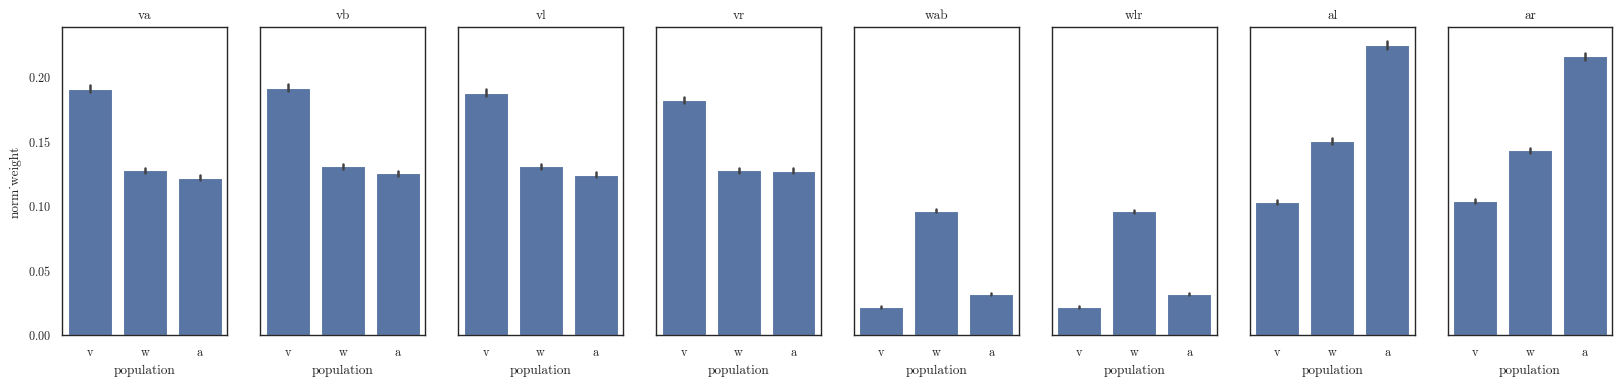

In [189]:
variables = neuron_weights['variable'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(20, 4), sharey=True)
for v, variable in enumerate(variables):
    # sns.barplot(neuron_weights.query("variable==@variable"), x='population', y='weight', ax=axes[v])
    sns.barplot(neuron_weights.query("variable==@variable"), x='population', y='norm_weight', ax=axes[v])
    axes[v].set(title=variable)
plt.show()

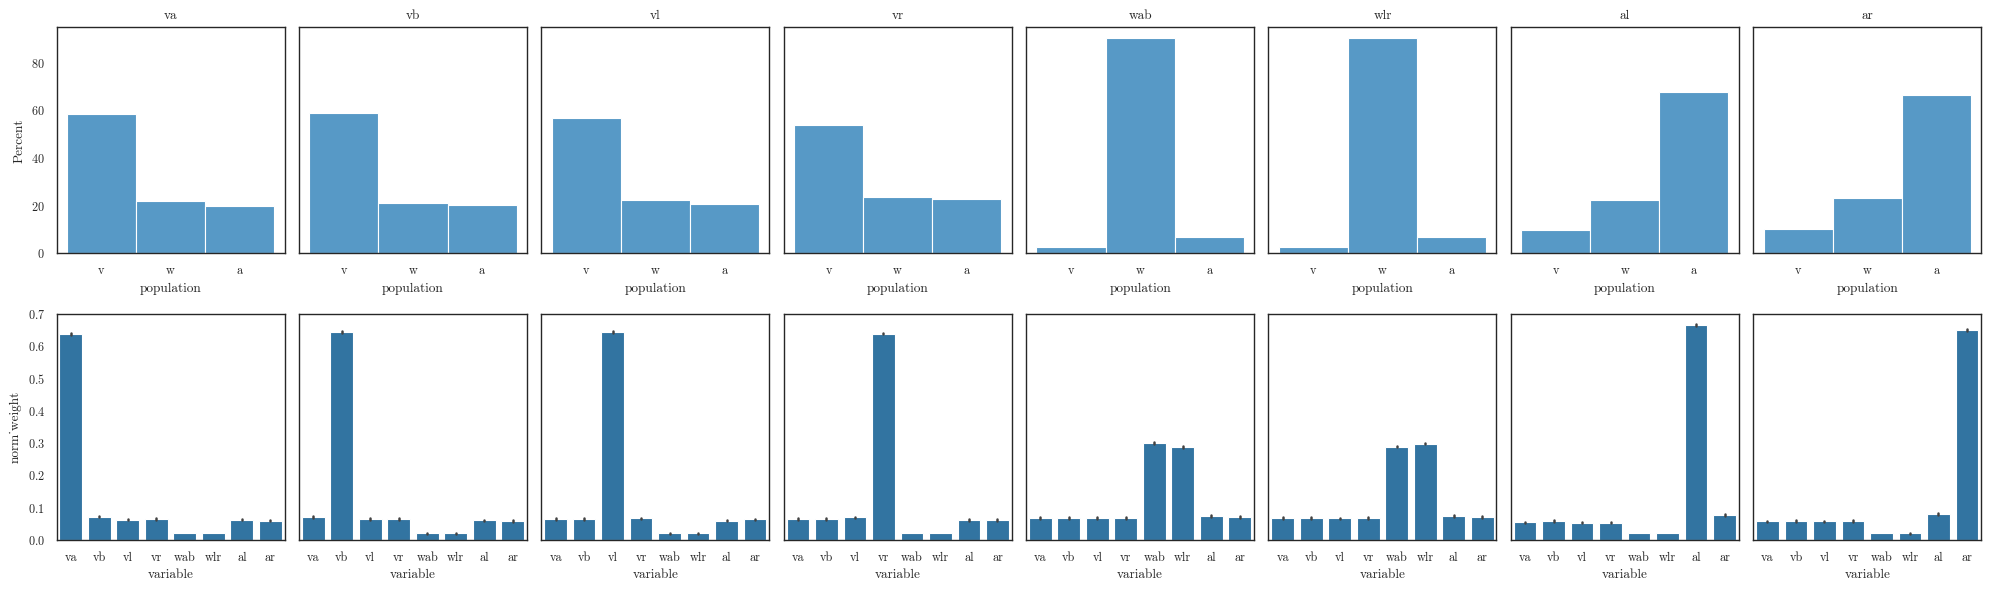

In [208]:
percentile = 95
variables = neuron_weights['variable'].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(variables), figsize=(20, 6), sharey='row')
for v, variable in enumerate(variables):
    nw = neuron_weights.query("variable==@variable")
    thr = np.percentile(nw['norm_weight'].to_numpy(), percentile)
    top = nw.query("norm_weight>=@thr")
    sns.histplot(top, x='population', ax=axes[0][v], stat='percent', color=palette[0])
    # look at the neurons in top, and plot their norm_weights for all variables
    top_monkeys = top['monkey'].to_numpy()
    top_sessions = top['session'].to_numpy()
    top_neurons = top['neuron'].to_numpy()
    key_df = pd.DataFrame({'monkey': top_monkeys, 'session': top_sessions, 'neuron': top_neurons})
    filtered_df = neuron_weights.merge(key_df, on=['monkey', 'session', 'neuron'], how='inner')
    sns.barplot(filtered_df, x='variable', y='norm_weight', ax=axes[1][v], color=palette[0])
    axes[0][v].set(title=variable)
plt.tight_layout()
plt.show()

In [38]:
nef_weights_wide = neuron_weights.pivot_table(index='neuron', columns='variable', values='norm_weight', fill_value=0)
print(nef_weights_wide)

NameError: name 'neuron_weights' is not defined

## Monkey

In [34]:
monkey_neuron_weights = spike_entropy(monkey_spikes, rl_values, 'monkey', 'rl', normalization='neuron')

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


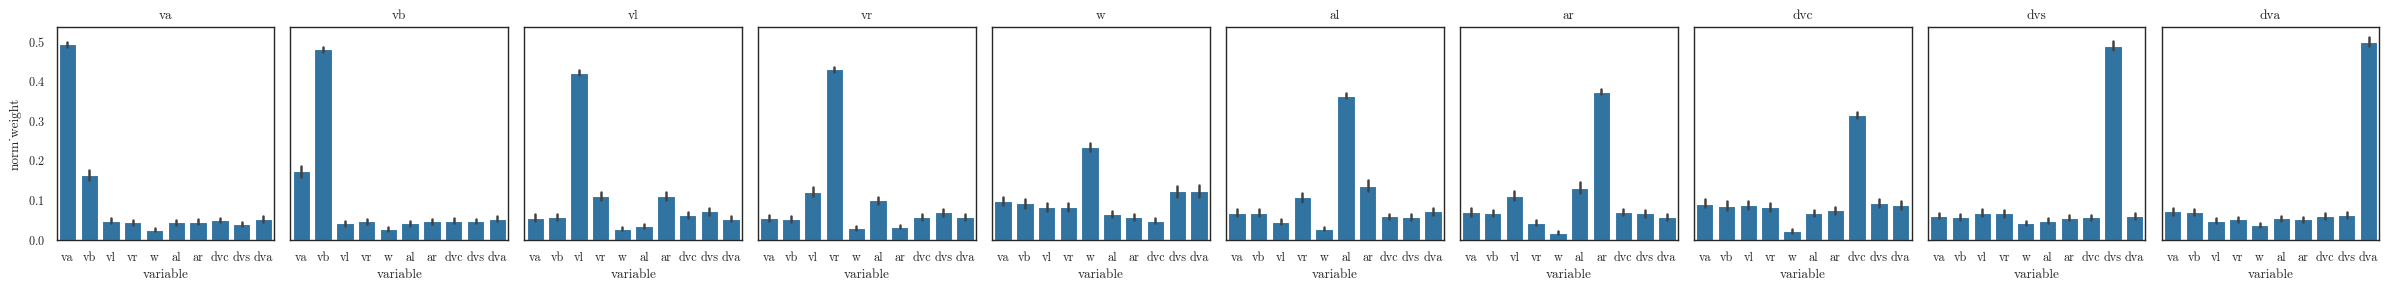

In [36]:
percentile = 95
variables = monkey_neuron_weights['variable'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(24, 3), sharey='row')
for v, variable in enumerate(variables):
    nw = monkey_neuron_weights.query("variable==@variable")
    thr = np.percentile(nw['norm_weight'].to_numpy(), percentile)
    top = nw.query("norm_weight>=@thr")
    # look at the neurons in top, and plot their norm_weights for all variables
    top_monkeys = top['monkey'].to_numpy()
    top_sessions = top['session'].to_numpy()
    top_neurons = top['neuron'].to_numpy()
    key_df = pd.DataFrame({'monkey': top_monkeys, 'session': top_sessions, 'neuron': top_neurons})
    filtered_df = monkey_neuron_weights.merge(key_df, on=['monkey', 'session', 'neuron'], how='inner')
    sns.barplot(filtered_df, x='variable', y='norm_weight', ax=axes[v], color=palette[0])
    axes[v].set(title=variable)
plt.tight_layout()
plt.show()

In [37]:
monkey_neuron_weights

,monkey,session,neuron,population,variable,weight,norm_weight,entropy
0,V,0,0,all,va,6.586868e-06,0.094411,1.703125
1,V,0,1,all,va,1.662863e-07,0.001678,1.280867
2,V,0,2,all,va,2.576102e-04,0.178485,1.687278
3,V,0,3,all,va,8.866779e-05,0.245406,2.029110
4,V,0,4,all,va,1.867612e-06,0.002060,1.178365
...,...,...,...,...,...,...,...,...
62275,W,3,675,all,dva,3.299488e-05,0.062770,1.764239
62276,W,3,676,all,dva,3.934264e-05,0.051138,1.837252
62277,W,3,677,all,dva,2.956456e-04,0.358429,1.710099
62278,W,3,678,all,dva,6.831542e-09,0.000063,1.193141
